In [ ]:
!pip install efficientnet-pytorch
!pip install torchattacks

import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import torchattacks
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import random_split
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [ ]:
# Define the model class
class MelanomaModel(nn.Module):
    def __init__(self, out_size, dropout_prob=0.5):
        super(MelanomaModel, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
        self.efficient_net._fc = nn.Identity()  # Remove the original fully connected layer
        self.fc1 = nn.Linear(1280, 512)  # EfficientNet-b0 output features
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, out_size)
        self.dropout = nn.Dropout(dropout_prob) # Dropout layer

    def forward(self, x):
        x = self.efficient_net(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the saved model and weights from Google Drive
file_path = '/content/drive/My Drive/model_and_weights.pth'
checkpoint = torch.load(file_path, map_location=torch.device('cpu'))
model = checkpoint['architecture']
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print("Model and weights have been loaded from Google Drive:", file_path)


Mounted at /content/drive
Model and weights have been loaded from Google Drive: /content/drive/My Drive/model_and_weights.pth


In [ ]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = datasets.ImageFolder('/content/drive/My Drive/test', transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=12)
class_names = test_dataset.classes


In [ ]:
import os
import torch
import torchvision.transforms as transforms
import torchattacks  # Assuming you have torchattacks library installed

# Assuming test_loader1 is your DataLoader containing original images
# and class_names is a list or dictionary mapping class indices to names
adv_test_PGD_dataset_path = '/content/drive/My Drive/attackrealreal/PGD/'

epsilon = 0.035  # Maximum perturbation
alpha = epsilon / 10  # Step size
steps = 80  # Number of steps

# Define the PGD attack
attack_PGD = torchattacks.PGD(model, eps=epsilon, alpha=alpha, steps=steps)

# Generate adversarial examples and save them
adversarial_data_PGD = []

# Extract filenames from the dataset used by test_loader1
original_filenames = [sample[0] for sample in test_loader.dataset.samples]

for i, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    adv_data_PGD = attack_PGD(data, target)
    adv_data_PGD_cpu = adv_data_PGD.cpu()

    # Iterate over batch
    for j in range(len(adv_data_PGD)):
        original_filename = original_filenames[i * test_loader.batch_size + j]
        label = class_names[target[j]]

        # Create directory if not exists
        adv_image_PGD_save_path = os.path.join(adv_test_PGD_dataset_path, label)
        os.makedirs(adv_image_PGD_save_path, exist_ok=True)

        # Save adversarial image with the same name as original
        adv_image_filename = os.path.basename(original_filename)
        adv_image_save_path = os.path.join(adv_image_PGD_save_path, adv_image_filename)

        # Convert tensor to PIL image and save
        adv_image = transforms.ToPILImage()(adv_data_PGD[j].cpu())
        adv_image.save(adv_image_save_path)

        adversarial_data_PGD.append((adv_data_PGD, target))

print("PGD attack completed and adversarial examples saved.")


PGD attack completed and adversarial examples saved.


In [ ]:
import os
import torch
import torchvision.transforms as transforms
import torchattacks  # Assuming you have torchattacks library installed

# Assuming test_loader1 is your DataLoader containing original images
# and class_names is a list or dictionary mapping class indices to names
adv_test_BIM_dataset_path = '/content/drive/My Drive/attackrealreal/BIM/'

epsilon = 0.035  # Maximum perturbation
alpha = epsilon / 10  # Step size
steps = 10  # Number of steps for BIM

# Define the BIM attack
attack_BIM = torchattacks.BIM(model, eps=epsilon, alpha=alpha, steps=steps)

# Generate adversarial examples and save them
adversarial_data_BIM = []

# Extract filenames from the dataset used by test_loader1
original_filenames = [sample[0] for sample in test_loader.dataset.samples]

for i, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    adv_data_BIM = attack_BIM(data, target)
    adv_data_BIM_cpu = adv_data_BIM.cpu()

    # Iterate over batch
    for j in range(len(adv_data_BIM)):
        original_filename = original_filenames[i * test_loader.batch_size + j]
        label = class_names[target[j]]

        # Create directory if not exists
        adv_image_BIM_save_path = os.path.join(adv_test_BIM_dataset_path, label)
        os.makedirs(adv_image_BIM_save_path, exist_ok=True)

        # Save adversarial image with the same name as original
        adv_image_filename = os.path.basename(original_filename)
        adv_image_save_path = os.path.join(adv_image_BIM_save_path, adv_image_filename)

        # Convert tensor to PIL image and save
        adv_image = transforms.ToPILImage()(adv_data_BIM[j].cpu())
        adv_image.save(adv_image_save_path)

        adversarial_data_BIM.append((adv_data_BIM, target))

print("BIM attack completed and adversarial examples saved.")


BIM attack completed and adversarial examples saved.


In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder('/content/drive/My Drive/test', transform=data_transforms)
PGD_dataset = datasets.ImageFolder('/content/drive/My Drive/attackrealreal/PGD', transform=transforms.ToTensor())
BIM_dataset = datasets.ImageFolder('/content/drive/My Drive/attackrealreal/BIM', transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=12)
PGD_loader = DataLoader(PGD_dataset, batch_size=32, shuffle=False, num_workers=12)
BIM_loader = DataLoader(BIM_dataset, batch_size=32, shuffle=False, num_workers=12)
class_names_test = test_dataset.classes
class_names_PGD = PGD_dataset.classes
class_names_FGSM = BIM_dataset.classes

In [ ]:
def predict_image(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_acc = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
            all_acc.append(accuracy)

    accuracy = sum(all_acc) / len(all_acc)
    return all_preds, all_labels, accuracy

# Get predictions, labels, and accuracy for the test set
predictions_PGD, labels_PGD, accuracy_PGD = predict_image(model, PGD_loader, device, class_names_PGD)
predictions_BIM, labels_BIM, accuracy_BIM = predict_image(model, BIM_loader, device, class_names_FGSM)
predictions, labels, accuracy = predict_image(model, test_loader, device, class_names_test)

In [ ]:
test_image = datasets.ImageFolder('/content/drive/My Drive/test')
PGD_image = datasets.ImageFolder('/content/drive/My Drive/attackrealreal/PGD')
BIM_image = datasets.ImageFolder('/content/drive/My Drive/attackrealreal/BIM')

Randomly selected image 277:
Randomly selected image 277:
Randomly selected image 277:


(-0.5, 223.5, 223.5, -0.5)

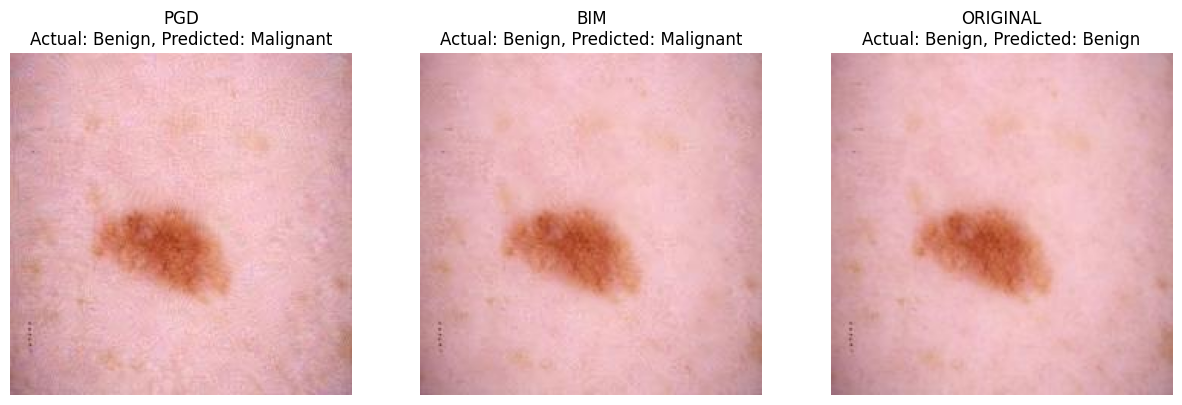

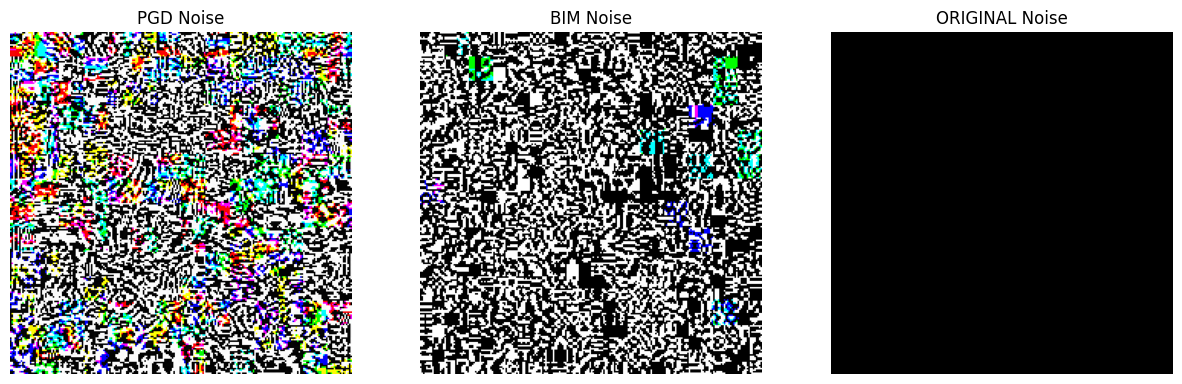

In [ ]:
import numpy as np
# Choose a random index
random_idx = random.randint(0, 1999)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#------------------------------------------------------------------------------
#PGD
pred_label_PGD = class_names_PGD[predictions_PGD[random_idx]]
actual_label_PGD = class_names_PGD[labels_PGD[random_idx]]

print(f"Randomly selected image {random_idx}:")

img_PGD , label_PGD = PGD_image[random_idx]
axs[0].imshow(img_PGD)
axs[0].set_title(f"PGD\nActual: {actual_label_PGD}, Predicted: {pred_label_PGD}")
axs[0].axis('off')
#------------------------------------------------------------------------------

#BIM
pred_label_BIM = class_names_FGSM[predictions_BIM[random_idx]]
actual_label_BIM = class_names_FGSM[labels_BIM[random_idx]]

print(f"Randomly selected image {random_idx}:")

img_BIM , label_BIM = BIM_image[random_idx]
axs[1].imshow(img_BIM)
axs[1].set_title(f"BIM\nActual: {actual_label_BIM}, Predicted: {pred_label_BIM}")
axs[1].axis('off')
#------------------------------------------------------------------------------

# Get the predicted and actual label
pred_label = class_names_test[predictions[random_idx]]
actual_label = class_names_test[labels[random_idx]]

print(f"Randomly selected image {random_idx}:")

img , label = test_image[random_idx]
axs[2].imshow(img)
axs[2].set_title(f"ORIGINAL\nActual: {actual_label}, Predicted: {pred_label}")
axs[2].axis('off')
#------------------------------------------------------------------------------
img_orig_np = np.array(img)
img_PGD_np = np.array(img_PGD)
img_BIM_np = np.array(img_BIM)
#------------------------------------------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display PGD Noise
noise_PGD = img_PGD_np - img_orig_np  # Calculate noise for PGD
axs[0].imshow(noise_PGD)
axs[0].set_title("PGD Noise")
axs[0].axis('off')
#------------------------------------------------------------------------------

# Display BIM Noise
noise_BIM = img_BIM_np - img_orig_np  # Calculate noise for BIM
axs[1].imshow(noise_BIM)
axs[1].set_title("BIM Noise")
axs[1].axis('off')

noise = img_orig_np - img_orig_np
axs[2].imshow(noise)
axs[2].set_title("ORIGINAL Noise")
axs[2].axis('off')